# Packages

In [1]:
import os
import json
import logging
from itertools import combinations
import sys

import math

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union, nearest_points
from shapely.geometry import LineString

import networkx as nx
import osmnx as ox

import scipy
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

import folium
from folium import GeoJson, LayerControl
from branca.colormap import linear
import branca.colormap as cm

import igraph as ig
import concurrent.futures

Cannot find header.dxf (GDAL_DATA is not defined)


# Functions

In [2]:
def tag_flooded_roads(edges, nodes, flood_zones, name):
    output_path = cut_roads_files[name]
    graphml_path = safe_roads_files[name]

    #if os.path.exists(output_path) and layer in fiona.listlayers(output_path):
    if os.path.exists(output_path):
        print(f"Loading {name} from {output_path}")
        G_safe = ox.load_graphml(graphml_path)
        edges = gpd.read_file(output_path, layer=name)
        
    else:
        print(f"Tagging and saving {name} to {output_path}")

        bounds = edges.total_bounds
        flood_subset = flood_zones.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        flood_geoms = flood_subset.geometry

        edges = edges.copy()
        edges["in_flood_zone"] = edges.geometry.apply(lambda geom: flood_geoms.intersects(geom).any())

        edges.to_file(output_path, layer=name, driver="GPKG")

    if os.path.exists(graphml_path):
        print("Pruned graph already exists")
    else:    
        safe_edges = edges[~edges["in_flood_zone"]].copy()
        print("Rebuilding pruned graph...")
        G_safe = ox.graph_from_gdfs(nodes, safe_edges)
        ox.save_graphml(G_safe, filepath=graphml_path)
        print(f"Saved pruned graph to {graphml_path}")

    return edges, G_safe

In [3]:
def clip_flood_zone(return_crs, name, clip_geom):
    output_path = zone_output_files[name]
    input_path = zone_input_files[name]
    
    if os.path.exists(output_path):
        print(f"Loading {name} from {output_path}")
        clipped = gpd.read_file(output_path, layer=name).to_crs(return_crs)
    else:
        print(f"Clipping and saving {name} from {output_path}" )
        flood = gpd.read_file(input_path).to_crs(return_crs)
        clipped = gpd.clip(flood, clip_geom)
        clipped.to_file(output_path, layer=name, driver="GPKG")

    return clipped

In [4]:
def make_geojson_safe(gdf):
    gdf = gdf.copy()
    dt_cols = gdf.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    gdf[dt_cols] = gdf[dt_cols].astype(str)
    for col in gdf.columns:
        if col != "geometry" and not pd.api.types.is_scalar(gdf[col].iloc[0]):
            gdf.drop(columns=[col], inplace=True)
    return gdf

In [5]:
def add_flood_zone_layer(name, m):
    gdf=flood_zones_var[name]
    color=color_palette[name]
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)

    gdf_serializable = make_geojson_safe(gdf)

    style_function = lambda x: {
        'fillColor': color,
        'color': color,
        'weight': 1,
        'fillOpacity': 0.4
    }

    geojson = folium.GeoJson(
        data=gdf_serializable,
        name=f"Flood {name}",
        style_function=style_function,
        show=False
    )
    geojson.add_to(m)

In [6]:
def add_roads_layer(name, m, flood):
    if flood:
        roads = flood_edges_var[name].copy()
        roads = roads[roads["in_flood_zone"] == flood]
    else:
        roads = edges.copy()

    roads = roads.to_crs(epsg=4326)
    roads = make_geojson_safe(roads)

    style_function = lambda x: {
        'color': color_palette[name],
        'weight': 2,
        'opacity': 0.6
    }

    if flood == True:
        geojson = folium.GeoJson(
            roads,
            name=f"Flooded Roads {name}",
            style_function=style_function,
            show=False
        )
    else:
            geojson = folium.GeoJson(
            roads,
            name=f"All roads",
            style_function=style_function,
            show=False
        )
    
    geojson.add_to(m)

In [7]:
def add_roads_layer_risk(name, m, flood):
    if flood:
        roads = flood_edges_var[name].copy()
        roads = roads[roads["in_flood_zone"] == flood]
    else:
        roads = edges.copy()

    roads = roads.to_crs(epsg=4326)
    roads = make_geojson_safe(roads)

    style_function = lambda x: {
        'color': color_palette[name],
        'weight': 2,
        'opacity': 0.6
    }

    if flood == True:
        geojson = folium.GeoJson(
            roads,
            name=f"Flooded Roads {name}",
            style_function=style_function,
            show=False
        )
    else:
            geojson = folium.GeoJson(
            roads,
            name=f"All roads",
            style_function=style_function,
            show=False
        )
    
    geojson.add_to(m)

In [8]:
def parse_depth_range(val):
    if pd.isna(val):
        return None

    val = val.strip()

    if val.startswith('Below'):
        return float(val[5:].strip()) / 2

    if val.startswith('>'):
        return float(val[1:].strip())  # You may want to cap it

    if '-' in val:
        parts = val.split('-')
        try:
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return (low + high) / 2
        except:
            return None

    try:
        return float(val)
    except:
        return None

In [9]:
def compute_individual_risk_factor(T_P, T_NP):
    if T_P == 0:
        return 1
    else:
        return 1 - (T_NP / T_P)

In [10]:
def compute_risk_factor(T_P_dict, T_NP_dict):
    keys = set(T_P_dict.keys()) & set(T_NP_dict.keys())
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k][1]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

In [11]:
def compute_risk_factor_2(T_P_dict, T_NP_dict): #when not computing paths
    keys = set(T_P_dict.keys()) & set(T_NP_dict.keys())
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

In [12]:
def compute_municipal_risk_factor(T_P_dict, T_NP_dict, municipality):
    keys = {k for k in T_P_dict.keys() & T_NP_dict.keys() if municipality in k}
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k][1]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

In [13]:
def flood_depth_zones(name):
    layer="depth_val"
    input_path = depth_input_files[name]
    output_path=depth_output_files[name]
    if os.path.exists(output_path):
        print(f"Loading {layer} from {output_path}")
        depth=gpd.read_file(output_path, layer=layer)
    else:
        print(f"Saving {layer} to {output_path}")
        depth = gpd.read_file(input_path)
        depth["depth_val"] = depth["value"].apply(parse_depth_range)
        depth.to_file(output_path, layer=layer, driver="GPKG")
        print(f"Saved processed {layer} in {output_path}")
    return depth

In [14]:
def convert_nx_to_igraph(G_nx, weight_attr='travel_time'):
    node_list = list(G_nx.nodes())
    node_to_index = {node: i for i, node in enumerate(node_list)}
    index_to_node = {i: node for node, i in node_to_index.items()}

    edge_weights = {}
    for u, v, attr in G_nx.edges(data=True):
        wt = attr.get(weight_attr)
        if wt is None:
            continue
        u_idx, v_idx = node_to_index[u], node_to_index[v]
        if (u_idx, v_idx) not in edge_weights or wt < edge_weights[(u_idx, v_idx)]:
            edge_weights[(u_idx, v_idx)] = wt

    is_directed = G_nx.is_directed()
    G_ig = ig.Graph(directed=is_directed)
    G_ig.add_vertices(len(node_list))
    G_ig.add_edges(edge_weights.keys())
    G_ig.es['weight'] = list(edge_weights.values())

    return G_ig, node_to_index, index_to_node, edge_weights


In [15]:
def batch_shortest_paths(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni, compute_path, weight_attr='weight'):
    result = {}
    special_indices = [node_to_index[n] for n in special_nodes]
    index_to_muni = {idx: node_to_muni[index_to_node[idx]] for idx in special_indices}

    for src_idx in special_indices:
        distances = G_ig.distances(source=src_idx, target=special_indices, weights=weight_attr)[0]
        paths = None
        if compute_path:
            paths = G_ig.get_shortest_paths(src_idx, to=special_indices, weights=weight_attr, output='vpath')

        for tgt_pos, tgt_idx in enumerate(special_indices):
            if src_idx == tgt_idx:
                continue

            dist = distances[tgt_pos]
            if math.isinf(dist):
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = ([], 0) if compute_path else 0
                continue

            if compute_path:
                node_path = paths[tgt_pos]
                path = [index_to_node[n] for n in node_path] if node_path else []
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = (path, dist)
            else:
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = dist

    return result

In [16]:
def batch_shortest_paths_no_path(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni, weight_attr='weight'):
    result = {}

    special_indices = [node_to_index[n] for n in special_nodes]
    index_to_muni = {idx: node_to_muni[index_to_node[idx]] for idx in special_indices}

    dist_matrix = G_ig.shortest_paths_dijkstra(
        source=special_indices,
        target=special_indices,
        weights=weight_attr
    )

    for i, src_idx in enumerate(special_indices):
        for j, tgt_idx in enumerate(special_indices):
            if src_idx == tgt_idx:
                continue

            dist = dist_matrix[i][j]
            key = f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"
            result[key] = 0 if math.isinf(dist) else dist

    return result


In [17]:
def load_or_compute_shortest_paths(filename, G_nx, special_nodes, node_to_muni, save, compute_path):
    G_ig, node_to_index, index_to_node, edge_weights = convert_nx_to_igraph(G_nx, weight_attr='travel_time')

    if os.path.exists(filename):
        with open(filename, 'r') as f:
            data = json.load(f)

        # Deserialize: convert lists to tuples if compute_path is True
        if compute_path:
            result = {k: (v[0], v[1]) for k, v in data.items()}
        else:
            result = data  # just distances
    else:
        print("Computing shortest paths...")
        result = batch_shortest_paths(
            G_ig,
            special_nodes,
            index_to_node,
            node_to_index,
            node_to_muni,
            compute_path=compute_path
        )

        if save:
            if compute_path:
                # Convert tuples to lists for JSON compatibility
                serializable_result = {k: [v[0], v[1]] for k, v in result.items()}
            else:
                # Values are just floats
                serializable_result = result

            with open(filename, 'w') as f:
                json.dump(serializable_result, f)

    return result

In [18]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Street data

In [20]:
output_dir = "processed_files"
os.makedirs(output_dir, exist_ok=True)

In [21]:
ox.settings.use_cache = True
ox.settings.log_console = False

In [24]:
polygon_path = os.path.join(output_dir, "study_area.geojson")
graph_path = os.path.join(output_dir, "road_graph.graphml")

valencia_municipalities = ["Alaquàs", "Albal", "Albalat de la Ribera", "Alberic", "Alborache", "Alcàsser", "l'Alcúdia", "Aldaia", "Alfafar", "Alfarb", "Algemesí", 
                           "Alginet", "Almussafes", "Alzira", "Aras de los Olmos", "Barxeta", "Benagéber", "Benaguasil", "Benetússer", "Benicull de Xúquer", 
                           "Benifaió", "Benimuslem", "Beniparrell", "Benimodo", "Bétera", "Bugarra", "Buñol", "Calles", "Camporrobles", "Carcaixent", "Carlet", 
                           "Casinos", "Castelló de la Ribera", "Catadau", "Catarroja", "Caudete de las Fuentes", "Chelva","Chera", "Cheste", "Chiva", "Chulilla", 
                           "Corbera", "Cullera", "Dos Aguas", "Favara", "Fortaleny", "Fuenterrobles", "Gavarda", "Gestalgar", "Godelleta", "Guadassuar", "l'Ènova", 
                           "Llaurí", "Llombai", "Llíria", "Llocnou de la Corona", "Loriguilla", "Losa del Obispo", "Macastre", "Manises", "Manuel", "Massalavés", 
                           "Massanassa", "Millares", "Mislata", "Montroi", "Montserrat", "Paiporta", "Paterna", "Pedralba", "Picanya", "Picassent", 
                           "Polinyà de Xúquer", "La Pobla Llarga", "Quart de Poblet", "Rafelguaraf", "Real", "Requena", "Riba-roja de Túria", "Riola", 
                           "Sant Joanet", "Sedaví", "Senyera", "Siete Aguas", "Silla", "Sinarcas", "Sollana", "Sot de Chera", "Sueca", "Tavernes de la Valldigna", 
                           "Titaguas", "Torrent", "Tous", "Tuéjar", "Turís", "Utiel", "València", "Vilamarxant", "Villar del Arzobispo", "Xeraco", "Xirivella", 
                           "Yátova"]

urban_center={
    "Alaquàs": (39.457119, -0.460822), 
    "Albal": (39.397347, -0.413243), 
    "Albalat de la Ribera": (39.201133, -0.386659),
    "Alberic": (39.116783, -0.517571),
    "Alborache": (39.391716, -0.771191),
    "Alcàsser": (39.369810, -0.445176),
    "l'Alcúdia": (39.194077, -0.507206),
    "Aldaia": (39.464957, -0.460764),
    "Alfafar": (39.422773, -0.390834), 
    "Alfarb": (39.276849, -0.560529),
    "Algemesí": (39.188743, -0.436927),
    "Alginet": (39.261819, -0.469791),
    "Almussafes": (39.292656, -0.413260),
    "Alzira": (39.152038, -0.441074),
    "Aras de los Olmos": (39.924534, -1.132748),
    "Barxeta": (39.022865, -0.416099),
    "Benagéber": (39.707324, -1.100825),
    "Benaguasil": (39.593635, -0.585004),
    "Benetússer": (39.423801, -0.397785),
    "Benicull de Xúquer": (39.185063, -0.382524), 
    "Benifaió": (39.285003, -0.426889),
    "Benimuslem": (39.131337, -0.492750),
    "Beniparrell": (39.382235, -0.412277), 
    "Benimodo": (39.213015, -0.528357), 
    "Bétera": (39.591643, -0.462355),
    "Bugarra": (39.608415, -0.775958), 
    "Buñol": (39.418217, -0.790672), 
    "Calles": (39.725371, -0.973952), 
    "Camporrobles": (39.647167, -1.399476), 
    "Carcaixent": (39.122600, -0.450718), 
    "Carlet": (39.225881, -0.519809),
    "Casinos": (39.701574, -0.709655),
    "Castelló de la ribera": (39.079664, -0.514174),
    #"Castielfabib": (40.131018, -1.303874),
    "Catadau": (39.275363, -0.569740), 
    "Catarroja": (39.403048, -0.404021),
    "Caudete de las Fuentes": (39.558958, -1.278492),
    "Chelva": (39.747097, -0.997692),
    "Chera": (39.593442, -0.973241), 
    "Cheste": (39.494909, -0.684261), 
    "Chiva": (39.471469, -0.717100), 
    "Chulilla": (39.656217, -0.891905), 
    "Corbera": (39.158264, -0.355378), 
    "Cullera": (39.165250, -0.253612),
    "Dos Aguas": (39.288825, -0.800238), 
    "Favara": (39.127275, -0.291808), 
    "Fortaleny": (39.183833, -0.313715), 
    "Fuenterrobles": (39.584682, -1.364031),
    "Gavarda": (39.090082, -0.545045),
    "Gestalgar": (39.604207, -0.834346), 
    "Godelleta": (39.422040, -0.686434), 
    "Guadassuar": (39.185852, -0.478023),
    "l'Ènova": (39.045134, -0.480790), 
    "Llaurí": (39.147102, -0.330235), 
    "Llombai": (39.282414, -0.572366), 
    "Llíria": (39.624719, -0.595006), 
    "Llocnou de la Corona": (39.420446, -0.382216), 
    "Loriguilla": (39.489698, -0.571964),
    "Losa del Obispo": (39.695444, -0.871960),
    "Macastre": (39.381938, -0.785287),
    "Manises": (39.493345, -0.457466), 
    "Manuel": (39.052760, -0.494055),
    "Massalavés": (39.140675, -0.521159),
    "Massanassa": (39.411460, -0.397986), 
    "Millares": (39.238985, -0.773203), 
    "Mislata": (39.475218, -0.417833), 
    "Montroi": (39.341742, -0.613689), 
    "Montserrat": (39.358012, -0.603212), 
    "Paiporta": (39.429588, -0.417467),
    "Paterna": (39.500663, -0.439682), 
    "Pedralba": (39.604864, -0.726535), 
    "Picanya": (39.435146, -0.433490), 
    "Picassent": (39.362746, -0.458078), 
    "Polinyà de Xúquer": (39.196150, -0.369461), 
    "La Pobla Llarga": (39.085916, -0.475557),
    "Quart de Poblet": (39.483003, -0.442288), 
    "Rafelguaraf": (39.050797, -0.455126), 
    "Real": (39.335088, -0.609125), 
    "Requena": (39.487037, -1.098087), 
    "Riba-roja de Túria": (39.546926, -0.566891), 
    "Riola": (39.195261, -0.334682),
    "Sant Joanet": (39.072333, -0.486829),
    "Sedaví": (39.425005, -0.385783),
    "Senyera": (39.063613, -0.510467), 
    "Siete Aguas": (39.471633, -0.915872), 
    "Silla": (39.362679, -0.412147), 
    "Sinarcas": (39.733258, -1.229035), 
    "Sollana": (39.278009, -0.381457), 
    "Sot de Chera": (39.620816, -0.909344), 
    "Sueca": (39.202640, -0.310637),
    "Tavernes de la Valldigna": (39.071834, -0.267740),
    "Titaguas": (39.865889, -1.080723),
    "Torrent": (39.436931, -0.465889), 
    "Tous": (39.138561, -0.586636), 
    "Tuéjar": (39.763485, -1.039679),
    "Turís": (39.389834, -0.711107), 
    "Utiel": (39.566851, -1.206009), 
    "València": (39.469844, -0.376852), 
    "Vilamarxant": (39.567855, -0.622488),
    "Villar del Arzobispo": (39.730829, -0.825240),
    "Xeraco": (39.033395, -0.215323),
    "Xirivella": (39.463360, -0.428399),
    "Yátova":(39.385085, -0.808117),
    "Mira": (39.720949, -1.439225)
} 

print(len(valencia_municipalities))
print(len(urban_center))

102
103


In [25]:
if os.path.exists(polygon_path):
    logging.info("Loading saved study area polygon...")
    study_area = gpd.read_file(polygon_path)
else:
    logging.info("Downloading polygons for municipalities...")
    polygons = []

    for municipality in valencia_municipalities:
        try:
            place_name = f"{municipality}, Valencia, Spain"
            gdf = ox.geocode_to_gdf(place_name)

            if gdf.crs != "EPSG:4326":
                gdf = gdf.to_crs("EPSG:4326")

            polygons.append(gdf)
        except Exception as e:
            logging.warning(f"Error retrieving {municipality}: {e}", exc_info=True)

    # Add Mira from Cuenca (just in case)
    try:
        gdf = ox.geocode_to_gdf("Mira, Cuenca, Spain")
        if gdf.crs != "EPSG:4326":
            gdf = gdf.to_crs("EPSG:4326")
        polygons.append(gdf)
    except Exception as e:
        logging.warning(f"Error retrieving Mira: {e}", exc_info=True)

    study_area = gpd.GeoDataFrame(pd.concat(polygons, ignore_index=True), crs="EPSG:4326")
    study_area = study_area[study_area.geometry.notnull()]
    study_area.to_file(polygon_path, driver="GeoJSON")

2025-07-10 13:16:58,331 [INFO] Downloading polygons for municipalities...
C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
2025-07-10 13:17:15,516 [INFO] Created 103 records


In [29]:
study_area = study_area[study_area.geometry.type.isin(["Polygon", "MultiPolygon"])]
polygon = unary_union(study_area.geometry)
logging.info("Polygon geometry union complete.")

2025-07-10 13:18:49,073 [INFO] Polygon geometry union complete.


In [30]:
if os.path.exists(graph_path):
    logging.info("Loading saved road network graph...")
    G = ox.load_graphml(graph_path)
    
else:
    logging.info("Downloading road network...")

    G = ox.graph_from_polygon(
        polygon,
        network_type="drive",
        simplify=True,
        retain_all=False,
        truncate_by_edge=True
    )

    logging.info("Calculating travel times...")
    for u, v, k, data in G.edges(keys=True, data=True):
        if "length" in data:
            speed = None

            if "maxspeed" in data:
                maxspeed = data["maxspeed"]
                if isinstance(maxspeed, list):
                    speed = maxspeed[0]
                else:
                    speed = maxspeed

                try:
                    speed = float(str(maxspeed).split()[0])  # Handle "50 km/h" etc.
                except ValueError:
                    speed = None  # Fallback to highway-based speed below

            if speed is None:
                highway = data.get("highway", "")
                if isinstance(highway, list):
                    highway = highway[0]
                speed = {
                    "motorway": 120,
                    "motorway_link": 60,
                    "trunk": 100,
                    "primary": 80,
                    "secondary": 60,
                    "tertiary": 50,
                    "residential": 30,
                    "living_street": 10,
                    "unclassified": 40,
                    "service": 20
                }.get(highway, 50)  # fallback 50 km/h

            surface = data.get("surface", "").lower()
            surface_speed_factor = {
                "paved": 1.0,
                "asphalt": 1.0,
                "concrete": 1.0,
                "cobblestone": 0.8,
                "gravel": 0.7,
                "dirt": 0.6,
                "ground": 0.6,
                "sand": 0.5,
                "unpaved": 0.7,
                "compacted": 0.85,
                "fine_gravel": 0.9
            }
            for key, factor in surface_speed_factor.items():
                if key in surface:
                    speed *= factor
                    break 

            speed_mps = speed * 1000 / 3600
            data["travel_time"] = data["length"] / speed_mps
            data["travel_time"] += 5 # Turn penalty approximation

    ox.save_graphml(G, filepath=graph_path)
    logging.info("Graph saved.")

nodes, edges = ox.graph_to_gdfs(G)
logging.info("Converted graph to GeoDataFrames.")

2025-07-10 13:18:49,301 [INFO] Downloading road network...
2025-07-10 13:20:15,064 [INFO] Calculating travel times...
2025-07-10 13:20:27,121 [INFO] Graph saved.
2025-07-10 13:20:30,241 [INFO] Converted graph to GeoDataFrames.


In [31]:
node_coords = np.array([(geom.y, geom.x) for geom in nodes.geometry])
kdtree = cKDTree(node_coords)

if 'municipality' not in nodes.columns:
    nodes['municipality'] = ""

for name, (lat, lon) in urban_center.items():
    try:
        # Query closest node index
        _, idx = kdtree.query([lat, lon], k=1)
        nearest_node_idx = nodes.index[idx]
        nodes.at[nearest_node_idx, 'municipality'] = name
    except Exception as e:
        logging.warning(f"Error assigning municipality {name}: {e}")


for node_id, row in nodes.iterrows():
    G.nodes[node_id]['municipality'] = row['municipality']

ox.save_graphml(G, graph_path)
logging.info(f"Updated graph saved to: {graph_path}")        

2025-07-10 13:20:43,637 [INFO] Updated graph saved to: processed_files\road_graph.graphml


In [32]:
from scipy.spatial import cKDTree

if 'municipality' not in nodes.columns:
    logging.info("Adding 'municipality' field to nodes...")

    nodes['municipality'] = ""

    node_coords = np.array([(geom.y, geom.x) for geom in nodes.geometry])
    kdtree = cKDTree(node_coords)

    for _, row in study_area.iterrows():
        name = row.get("name") or row.get("display_name") or "unknown"
        geom = row.geometry

        if not geom or not geom.is_valid or name == "Favara":
            continue

        try:
            muni_graph = ox.graph_from_polygon(geom, network_type='drive', simplify=True)
            center_node = ox.distance.nearest_nodes(muni_graph, X=geom.centroid.x, Y=geom.centroid.y)
            center_point = Point((muni_graph.nodes[center_node]['x'], muni_graph.nodes[center_node]['y']))
            _, idx = kdtree.query([center_point.y, center_point.x], k=1)
            nearest_node_idx = nodes.index[idx]
            nodes.at[nearest_node_idx, 'municipality'] = name

        except Exception as e:
            logging.warning(f"Could not process {name}: {e}")
            continue

    for node_id, row in nodes.iterrows():
        G.nodes[node_id]['municipality'] = row['municipality']

    graph_path = os.path.join(output_dir, "road_graph.graphml")
    ox.save_graphml(G, graph_path)
    logging.info(f"Updated graph saved to: {graph_path}")

else:
    logging.info("'municipality' field already exists in nodes.")

2025-07-10 13:20:43,653 [INFO] 'municipality' field already exists in nodes.


In [33]:
rail=False
if rail:
    graph_path_rail = os.path.join(output_dir, "study_area_rail.graphml")
    if os.path.exists(graph_path_rail):
        print("Loading saved rail network graph...")
        G_rail = ox.load_graphml(graph_path_rail)
    else:
        print("Downloading rail network graph...")
        rail_filter = '["railway"~"rail|light_rail|subway|tram"]'
        G_rail = ox.graph_from_polygon(polygon, custom_filter=rail_filter, network_type="all")
        ox.save_graphml(G_rail, filepath=graph_path_rail)

    nodes_rail, edges_rail = ox.graph_to_gdfs(G_rail)
    del G_rail

# Layers

In [34]:
input_dir = "source_files"
output_dir = "processed_files"
os.makedirs(output_dir, exist_ok=True)

In [35]:
zone_input_files = {
    "10 yr": f"{input_dir}/laminaspb-q10/Q10_2Ciclo_PB_20241121.shp",
    "100 yr": f"{input_dir}/laminaspb-q100/Q100_2Ciclo_PB_20241121_ETRS89.shp",
    "500 yr": f"{input_dir}/laminaspb-q500/Q500_2Ciclo_PB_20241121_ETRS89.shp",
    "DANA_31_10_2024": f"{input_dir}/EMSR773_AOI01_DEL_PRODUCT_v1/EMSR773_AOI01_DEL_PRODUCT_observedEventA_v1.shp",
    "DANA_03_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT01_v1/EMSR773_AOI01_DEL_MONIT01_observedEventA_v1.shp",
    "DANA_05_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT02_v1/EMSR773_AOI01_DEL_MONIT02_observedEventA_v1.shp",
    "DANA_06_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT03_v1/EMSR773_AOI01_DEL_MONIT03_observedEventA_v1.shp",
    "DANA_08_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT04_v1/EMSR773_AOI01_DEL_MONIT04_observedEventA_v1.shp"
}

depth_input_files = {
    "DANA_31_10_2024": f"{input_dir}/EMSR773_AOI01_DEL_PRODUCT_v1/EMSR773_AOI01_DEL_PRODUCT_floodDepthA_v1.shp",
    "DANA_03_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT01_v1/EMSR773_AOI01_DEL_MONIT01_floodDepthA_v1.shp",
    "DANA_05_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT02_v1/EMSR773_AOI01_DEL_MONIT02_floodDepthA_v1.shp",
    "DANA_06_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT03_v1/EMSR773_AOI01_DEL_MONIT03_floodDepthA_v1.shp",
    "DANA_08_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT04_v1/EMSR773_AOI01_DEL_MONIT04_floodDepthA_v1.shp"
}

zone_output_files = {
    "10 yr": f"{output_dir}/zone_flood_risk_10.gpkg",
    "100 yr": f"{output_dir}/zone_flood_risk_100.gpkg",
    "500 yr": f"{output_dir}/zone_flood_risk_500.gpkg",
    "DANA_31_10_2024": f"{output_dir}/zone_DANA_31_10_2024.gpkg",
    "DANA_03_11_2024": f"{output_dir}/zone_DANA_03_11_2024.gpkg",
    "DANA_05_11_2024": f"{output_dir}/zone_DANA_05_11_2024.gpkg",
    "DANA_06_11_2024": f"{output_dir}/zone_DANA_06_11_2024.gpkg",
    "DANA_08_11_2024": f"{output_dir}/zone_DANA_08_11_2024.gpkg"
}

depth_output_files = {
    "DANA_31_10_2024": f"{output_dir}/depth_DANA_31_10_2024.gpkg",
    "DANA_03_11_2024": f"{output_dir}/depth_DANA_03_11_2024.gpkg",
    "DANA_05_11_2024": f"{output_dir}/depth_DANA_05_11_2024.gpkg",
    "DANA_06_11_2024": f"{output_dir}/depth_DANA_06_11_2024.gpkg",
    "DANA_08_11_2024": f"{output_dir}/depth_DANA_08_11_2024.gpkg"
}

cut_roads_files = {
    "10 yr": f"{output_dir}/cut_roads_flood_risk_10.graphml",
    "100 yr": f"{output_dir}/cut_roads_flood_risk_100.graphml",
    "500 yr": f"{output_dir}/cut_roads_flood_risk_500.graphml",
    "DANA_31_10_2024": f"{output_dir}/cut_roads_DANA_31_10_2024.graphml",
    "DANA_03_11_2024": f"{output_dir}/cut_roads_DANA_03_11_2024.graphml",
    "DANA_05_11_2024": f"{output_dir}/cut_roads_DANA_05_11_2024.graphml",
    "DANA_06_11_2024": f"{output_dir}/cut_roads_DANA_06_11_2024.graphml",
    "DANA_08_11_2024": f"{output_dir}/cut_roads_DANA_08_11_2024.graphml"
}

safe_roads_files = {
    "10 yr": f"{output_dir}/safe_roads_flood_risk_10.graphml",
    "100 yr": f"{output_dir}/safe_roads_flood_risk_100.graphml",
    "500 yr": f"{output_dir}/safe_roads_flood_risk_500.graphml",
    "DANA_31_10_2024": f"{output_dir}/safe_roads_DANA_31_10_2024.graphml",
    "DANA_03_11_2024": f"{output_dir}/safe_roads_DANA_03_11_2024.graphml",
    "DANA_05_11_2024": f"{output_dir}/safe_roads_DANA_05_11_2024.graphml",
    "DANA_06_11_2024": f"{output_dir}/safe_roads_DANA_06_11_2024.graphml",
    "DANA_08_11_2024": f"{output_dir}/safe_roads_DANA_08_11_2024.graphml"
}

shortest_path_files = {
    "Normal Conditions": f"{output_dir}/shorthest_paths_NP.json", 
    "10 yr": f"{output_dir}/shorthest_paths_10.json",
    "100 yr": f"{output_dir}/shorthest_paths_100.json",
    "500 yr": f"{output_dir}/shorthest_paths_500.json",
    "DANA_31_10_2024": f"{output_dir}/shorthest_paths_DANA_31_10_2024.json",
    "DANA_03_11_2024": f"{output_dir}/shorthest_paths_DANA_03_11_2024.json",
    "DANA_05_11_2024": f"{output_dir}/shorthest_paths_DANA_05_11_2024.json",
    "DANA_06_11_2024": f"{output_dir}/shorthest_paths_DANA_06_11_2024.json",
    "DANA_08_11_2024": f"{output_dir}/shorthest_paths_DANA_08_11_2024.json"
}

# Flood zones

In [36]:
layer_names=["10 yr","100 yr","500 yr","DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
#layer_names=["DANA_31_10_2024"]
flood_zones_var = {}
flood_edges_var = {}
flood_graph_var = {}

In [37]:
for name in layer_names: 
    result = clip_flood_zone(edges.crs, name, polygon)
    flood_zones_var[name] = result
    result_1, result_2 = tag_flooded_roads(edges, nodes, result, name)
    flood_edges_var[name] = result_1
    flood_graph_var[name] = result_2 

Clipping and saving 10 yr from processed_files/zone_flood_risk_10.gpkg


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Cannot find tms_NZTM2000.json (GDAL_DATA is not defined)
  ogr_write(
2025-07-10 13:21:20,476 [INFO] Created 63 records


Tagging and saving 10 yr to processed_files/cut_roads_flood_risk_10.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:22:22,777 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_10.graphml
Clipping and saving 100 yr from processed_files/zone_flood_risk_100.gpkg


2025-07-10 13:23:24,196 [INFO] Created 67 records


Tagging and saving 100 yr to processed_files/cut_roads_flood_risk_100.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:25:12,558 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_100.graphml
Clipping and saving 500 yr from processed_files/zone_flood_risk_500.gpkg


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: source_files/laminaspb-q500/Q500_2Ciclo_PB_20241121_ETRS89.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
2025-07-10 13:26:24,079 [INFO] Created 69 records


Tagging and saving 500 yr to processed_files/cut_roads_flood_risk_500.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:33:08,688 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_500.graphml
Clipping and saving DANA_31_10_2024 from processed_files/zone_DANA_31_10_2024.gpkg


2025-07-10 13:33:27,243 [INFO] Created 1,360 records


Tagging and saving DANA_31_10_2024 to processed_files/cut_roads_DANA_31_10_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:33:47,489 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_31_10_2024.graphml
Clipping and saving DANA_03_11_2024 from processed_files/zone_DANA_03_11_2024.gpkg


2025-07-10 13:34:04,251 [INFO] Created 791 records


Tagging and saving DANA_03_11_2024 to processed_files/cut_roads_DANA_03_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:34:28,073 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_03_11_2024.graphml
Clipping and saving DANA_05_11_2024 from processed_files/zone_DANA_05_11_2024.gpkg


2025-07-10 13:34:45,798 [INFO] Created 495 records


Tagging and saving DANA_05_11_2024 to processed_files/cut_roads_DANA_05_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:34:56,380 [INFO] Created 134,342 records


Rebuilding pruned graph...


2025-07-10 13:35:13,173 [INFO] Created 60 records


Saved pruned graph to processed_files/safe_roads_DANA_05_11_2024.graphml
Clipping and saving DANA_06_11_2024 from processed_files/zone_DANA_06_11_2024.gpkg
Tagging and saving DANA_06_11_2024 to processed_files/cut_roads_DANA_06_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:35:19,642 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_06_11_2024.graphml
Clipping and saving DANA_08_11_2024 from processed_files/zone_DANA_08_11_2024.gpkg


2025-07-10 13:35:37,804 [INFO] Created 269 records


Tagging and saving DANA_08_11_2024 to processed_files/cut_roads_DANA_08_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-10 13:35:44,988 [INFO] Created 134,342 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_08_11_2024.graphml


In [38]:
layer_names = ["DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
depth_zones = {}

In [39]:
for name in layer_names: 
    depth = flood_depth_zones(name)
    depth_zones[name]=depth

2025-07-10 13:36:01,288 [INFO] Created 3,216 records


Saving depth_val to processed_files/depth_DANA_31_10_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_31_10_2024.gpkg
Saving depth_val to processed_files/depth_DANA_03_11_2024.gpkg


2025-07-10 13:36:01,531 [INFO] Created 1,968 records
2025-07-10 13:36:01,626 [INFO] Created 1,478 records
2025-07-10 13:36:01,689 [INFO] Created 195 records


Saved processed depth_val in processed_files/depth_DANA_03_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_05_11_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_05_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_06_11_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_06_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_08_11_2024.gpkg


2025-07-10 13:36:01,752 [INFO] Created 440 records


Saved processed depth_val in processed_files/depth_DANA_08_11_2024.gpkg


# Navegability Analysis

In [40]:
filename = shortest_path_files["Normal Conditions"]

special_nodes = [n for n, attr in G.nodes(data=True) if attr.get('municipality')]
node_to_muni = {n: attr.get('municipality', '') for n, attr in G.nodes(data=True)}

T_NP_dictionary = load_or_compute_shortest_paths(filename, G, special_nodes, node_to_muni,True,True)

Computing shortest paths...


In [41]:
for name, graph in flood_graph_var.items():
    components = list(nx.weakly_connected_components(graph))
    
    multi_muni_count = sum(
        1 for component in components
        if len({graph.nodes[node]["municipality"] for node in component if graph.nodes[node]["municipality"] != ""}) > 0
    )

    print(f"{name} {multi_muni_count} weakly connected components")

    if multi_muni_count > 0:
        j = 0
        for i, component in enumerate(components):
            municipalities = {
                graph.nodes[node]["municipality"]
                for node in component
                if graph.nodes[node]["municipality"] != ""
            }
            if len(municipalities) > 0:
                j += 1
                print(f"Component {j} municipalities: {municipalities}")

10 yr 7 weakly connected components
Component 1 municipalities: {'Aldaia', 'Silla', 'Llíria', 'Benimodo', 'Fortaleny', 'Llombai', 'Sot de Chera', 'Alaquàs', 'Algemesí', 'Favara', 'Casinos', 'Albalat de la Ribera', 'Torrent', 'Polinyà de Xúquer', 'Paiporta', 'Chiva', 'Turís', 'Benicull de Xúquer', 'Alberic', 'Sueca', 'Beniparrell', 'Gestalgar', 'Bugarra', 'Massanassa', 'Cullera', 'Chera', 'Fuenterrobles', 'Alzira', 'Picanya', 'Mislata', 'Benaguasil', 'València', 'Benetússer', 'Godelleta', 'Siete Aguas', 'Riba-roja de Túria', 'Llocnou de la Corona', 'Macastre', 'Alborache', 'Pedralba', 'Gavarda', 'Sollana', 'Yátova', 'Llaurí', 'Manises', 'Benifaió', 'Albal', 'Sedaví', 'Almussafes', 'Guadassuar', 'Alfarb', 'Alginet', 'Montserrat', 'Paterna', 'Loriguilla', 'Riola', 'Picassent', 'Buñol', 'Benimuslem', 'Xirivella', 'Utiel', 'Cheste', 'Camporrobles', "l'Alcúdia", 'Chulilla', 'Alfafar', 'Villar del Arzobispo', 'Tavernes de la Valldigna', 'Losa del Obispo', 'Bétera', 'Carlet', 'Benagéber', 'Cat

In [42]:
layer_names=["10 yr","100 yr","500 yr","DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
#layer_names=["DANA_31_10_2024"]
T_P_dictionaries = {}
R={}

In [43]:
for i, name in enumerate(layer_names):
    T_P_dictionaries[name] = load_or_compute_shortest_paths(shortest_path_files[name], flood_graph_var[name], special_nodes, node_to_muni,True,True)
    R[name] = compute_risk_factor(T_P_dictionaries[name], T_NP_dictionary)
    
    percent_complete = (i + 1) / len(layer_names) * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i + 1}/{len(layer_names)})", end="")

Computing shortest paths...


C:\Users\usuario\AppData\Local\Temp\ipykernel_13752\2107593774.py:10: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  paths = G_ig.get_shortest_paths(src_idx, to=special_indices, weights=weight_attr, output='vpath')


Progress: 12.50% (1/8)Computing shortest paths...
Progress: 25.00% (2/8)Computing shortest paths...
Progress: 37.50% (3/8)Computing shortest paths...
Progress: 50.00% (4/8)Computing shortest paths...
Progress: 62.50% (5/8)Computing shortest paths...
Progress: 75.00% (6/8)Computing shortest paths...
Progress: 87.50% (7/8)Computing shortest paths...
Progress: 100.00% (8/8)

In [45]:
used_edges = set()

for path, _ in T_NP_dictionary.values():
    for u, v in zip(path, path[1:]):
        used_edges.add((u, v))


In [46]:
%%prun
G_ig, node_to_index, index_to_node, edge_weights = convert_nx_to_igraph(G, weight_attr='travel_time')  # <<< CHANGED (save edge_weights)
special_indices = [node_to_index[n] for n in special_nodes]

base_risk = 0
edge_risks = []
i=0
total = len(used_edges)
#total = 100

for u, v in list(used_edges)[:total]:
    i+=1
    u_idx, v_idx = node_to_index[u], node_to_index[v]
    eid = G_ig.get_eid(u_idx, v_idx, directed=True, error=False)  # <<< NEW (get edge id in igraph)
    if eid == -1:
        continue

    # Remove edge in-place
    G_ig.delete_edges(eid)  # <<< NEW (remove edge without copying)

    # Compute shortest paths after removal (without full paths)
    T_P_dictionary = batch_shortest_paths_no_path(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni)  # <<< CHANGED (use igraph)

    new_risk = compute_risk_factor_2(T_P_dictionary, T_NP_dictionary)
    delta_risk = new_risk - base_risk

    edge_risks.append(((u, v), delta_risk))

    # Re-add the edge with original weight
    G_ig.add_edges([(u_idx, v_idx)])  # <<< NEW (re-add edge)
    G_ig.es[-1]['weight'] = edge_weights[(u_idx, v_idx)]  # <<< NEW (set original weight)

    # Print progress (overwrite line)
    percent_complete = (i) / total * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i}/{total})", end="")
    sys.stdout.flush()

edge_risks.sort(key=lambda x: x[1], reverse=True)
edge_risks_json = [ {"edge": [u, v], "delta_risk": delta_risk} for (u, v), delta_risk in edge_risks ]
with open("processed_files/edge_risks_NP.json", "w") as f:
    json.dump(edge_risks_json, f, indent=2)

Progress: 0.01% (1/16615)

C:\Users\usuario\AppData\Local\Temp\ipykernel_13752\172459596.py:7: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = G_ig.shortest_paths_dijkstra(


 rogress: 100.00% (16615/16615)

         353343654 function calls (353260579 primitive calls) in 16898.255 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    16615 16333.057    0.983 16333.059    0.983 {method 'distances' of 'igraph._igraph.GraphBase' objects}
    16615  165.902    0.010  165.902    0.010 {function _delete_edges at 0x0000018A03209D80}
    16616  127.256    0.008  127.256    0.008 {function _add_edges at 0x0000018A03209BD0}
    16615  115.914    0.007  141.176    0.008 426513350.py:1(compute_risk_factor_2)
    16615   85.009    0.005 16433.838    0.989 172459596.py:1(batch_shortest_paths_no_path)
174557190   25.226    0.000   25.226    0.000 4263211823.py:1(compute_individual_risk_factor)
        1   11.687   11.687 16898.252 16898.252 <string>:1(<module>)
   133237   10.633    0.000   10.633    0.000 {method 'acquire' of '_thread.lock' objects}
174557190    8.891    0.000    8.891    0.000 {built-in method math.isinf}
    16615    4.547 

In [51]:
# Step 1: Convert reduced graph to igraph
G_ig_dana, node_to_index, index_to_node, _ = convert_nx_to_igraph(
    flood_graph_var["DANA_31_10_2024"], weight_attr='travel_time')

# Step 2: Prepare special node indices
special_indices = [node_to_index[n] for n in special_nodes]

# Step 3: Compute baseline risk for reduced graph
T_P_dictionary = batch_shortest_paths(
    G_ig_dana, special_nodes, index_to_node, node_to_index, node_to_muni, compute_path=False)

base_risk = compute_risk_factor(
    T_P_dictionaries["DANA_31_10_2024"], T_NP_dictionary)

# Step 4: Prepare candidate edges (only in flood zone)
candidate_edges = flood_edges_var["DANA_31_10_2024"]
candidate_edges = candidate_edges[candidate_edges['in_flood_zone'].astype(bool)].copy()

edge_risks = []
total = len(candidate_edges)

In [52]:
%%prun

# Step 5: Loop through candidate edges and evaluate impact
for i, ((u, v, _), row) in enumerate(candidate_edges.iterrows()):
    weight = row['travel_time']

    if u not in node_to_index or v not in node_to_index:
        continue

    u_idx, v_idx = node_to_index[u], node_to_index[v]

    # Add edge
    G_ig_dana.add_edges([(u_idx, v_idx)])
    eid = G_ig_dana.get_eid(u_idx, v_idx, directed=True, error=False)
    if eid == -1:
        continue

    G_ig_dana.es[eid]['weight'] = weight

    # Recompute risk
    T_P_dictionary = batch_shortest_paths_no_path(G_ig_dana, special_nodes, index_to_node, node_to_index, node_to_muni)
    new_risk = compute_risk_factor_2(T_P_dictionary, T_NP_dictionary)
    delta_risk = new_risk - base_risk

    edge_risks.append(((u, v), delta_risk))

    # Remove the edge
    G_ig_dana.delete_edges(eid)

    # Print progress
    percent_complete = (i + 1) / total * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i + 1}/{total})", end="")
    sys.stdout.flush()


edge_risks.sort(key=lambda x: x[1], reverse=True)

edge_risks_json = [ {"edge": [u, v], "delta_risk": delta_risk} for (u, v), delta_risk in edge_risks ]
with open("processed_files/edge_risks_DANA.json", "w") as f:
    json.dump(edge_risks_json, f, indent=2)


Progress: 0.01% (1/18679)

C:\Users\usuario\AppData\Local\Temp\ipykernel_13752\172459596.py:7: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = G_ig.shortest_paths_dijkstra(


 rogress: 100.00% (18679/18679)

         399082732 function calls (398914614 primitive calls) in 7690.797 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    18679 7061.023    0.378 7061.024    0.378 {method 'distances' of 'igraph._igraph.GraphBase' objects}
    18679  171.135    0.009  171.135    0.009 {function _delete_edges at 0x0000018A03209D80}
    18679  141.044    0.008  164.645    0.009 426513350.py:1(compute_risk_factor_2)
    18679  129.662    0.007  129.662    0.007 {function _add_edges at 0x0000018A03209BD0}
    18679  103.893    0.006 7185.170    0.385 172459596.py:1(batch_shortest_paths_no_path)
196241574   23.555    0.000   23.555    0.000 4263211823.py:1(compute_individual_risk_factor)
        1   14.431   14.431 7690.796 7690.796 <string>:1(<module>)
   149759   11.889    0.000   11.889    0.000 {method 'acquire' of '_thread.lock' objects}
196241574   11.658    0.000   11.658    0.000 {built-in method math.isinf}
    18679    5.555    0.0

# Plots

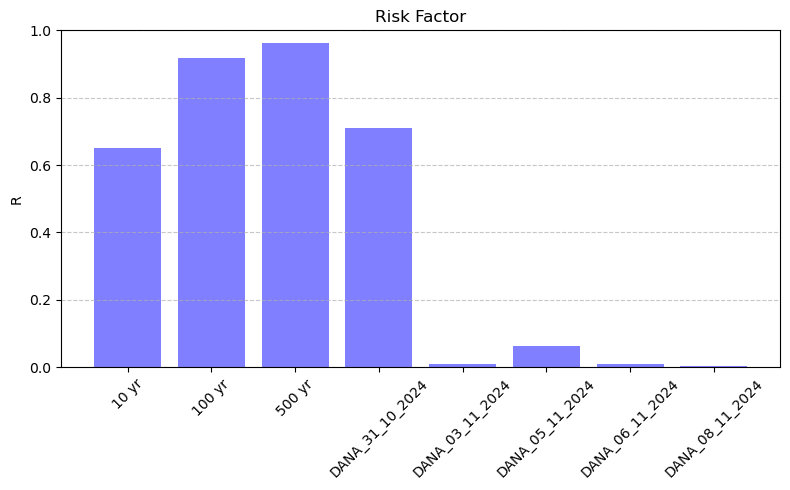

In [53]:
sorted_data = dict(sorted(R.items(), key=lambda item: item[1]))
keys = list(R.keys())
values = list(R.values())

plt.figure(figsize=(8, 5))
plt.bar(keys, values, color="Blue", alpha=0.5)

plt.ylim(0, 1)
plt.ylabel('R')
plt.title('Risk Factor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('processed_files/Risk_Factor.png')
plt.show()

In [54]:
color_palette = {
    # yr values — warm and spaced
    "10 yr": "#FFD700",    # Gold
    "100 yr": "#FF7F00",   # Dark Orange
    "500 yr": "#B22222",   # Firebrick 

    # DANA values — distinct, avoiding orange/red hues
    "DANA_31_10_2024": "#8A2BE2",  # Blue-Violet
    "DANA_03_11_2024": "#FF1493",  # Deep Pink
    "DANA_05_11_2024": "#00CED1",  # Dark Turquoise
    "DANA_06_11_2024": "#32CD32",  # Lime Green
    "DANA_08_11_2024": "#1E90FF",  # Dodger Blue

    # Normal condition
    "Normal Conditions": "#808080"  # Grey
}

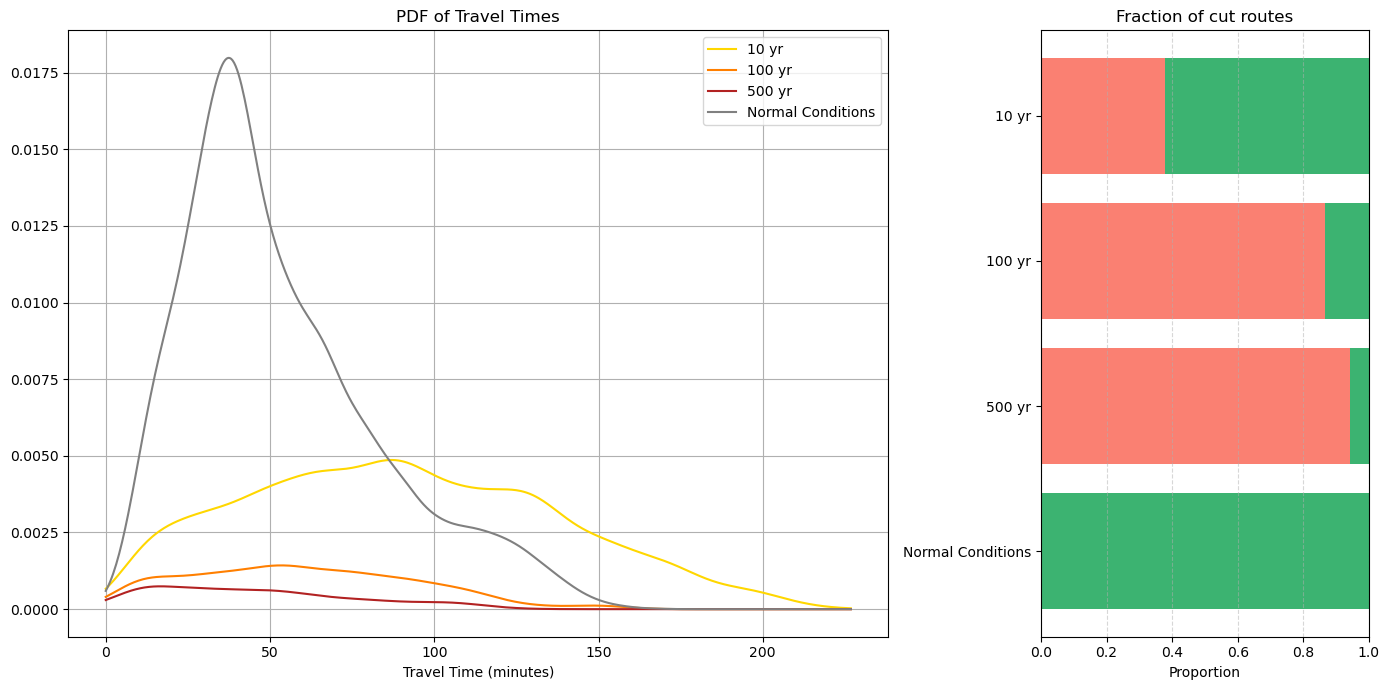

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

# --- Prepare data ---
plot_data = []
zero_counts = {}
all_counts = {}
layer_names = ["10 yr", "100 yr", "500 yr"]

# T_P_lists scenarios
for name, results_dict in T_P_dictionaries.items():
    if name in layer_names:
        travel_times = [v[1] for v in results_dict.values()]
        non_zero_times = [t / 60 for t in travel_times if t > 0]
        all_times = [t / 60 for t in travel_times]
        zero_counts[name] = travel_times.count(0)
        all_counts[name] = len(travel_times)
        plot_data.append((name, non_zero_times))

# Add normal scenario
normal_travel_times = [v[1] for v in T_NP_dictionary.values()]
normal_non_zero = [t / 60 for t in normal_travel_times if t > 0]
normal_total = len(normal_travel_times)
plot_data.append(("Normal Conditions", normal_non_zero))
all_counts["Normal Conditions"] = normal_total
zero_counts["Normal Conditions"] = normal_travel_times.count(0)

# --- KDE Plot ---
fig, (ax_kde, ax_bar) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2.5, 1]})

x_vals = np.linspace(0, max([max(times) if times else 0 for _, times in plot_data]), 500)

for name, times in plot_data:
    if len(times) > 1:
        kde = gaussian_kde(times)
        y = kde(x_vals)
        ratio = len(times) / all_counts[name] if all_counts[name] > 0 else 0
        y_rescaled = y * ratio
        color = color_palette.get(name, 'gray')  # fallback to gray if not defined
        ax_kde.plot(x_vals, y_rescaled, label=name, color=color)

ax_kde.set_title("PDF of Travel Times")
ax_kde.set_xlabel("Travel Time (minutes)")
ax_kde.grid(True)
ax_kde.legend(loc='upper right')

# --- Reachability Bar Chart ---
scenarios = layer_names + ["Normal Conditions"]
reachable = [(all_counts[n] - zero_counts[n]) / all_counts[n] if all_counts[n] > 0 else 0 for n in scenarios]
unreachable = [1 - r for r in reachable]

bar_positions = np.arange(len(scenarios))
ax_bar.barh(bar_positions, unreachable, color='salmon', label='Unreachable')
ax_bar.barh(bar_positions, reachable, left=unreachable, color='mediumseagreen', label='Reachable')

ax_bar.set_yticks(bar_positions)
ax_bar.set_yticklabels(scenarios)
ax_bar.set_xlim(0, 1)
ax_bar.set_title("Fraction of cut routes")
ax_bar.set_xlabel("Proportion")
#ax_bar.legend(loc='lower right')
ax_bar.grid(axis='x', linestyle='--', alpha=0.5)

ax_bar.invert_yaxis()

plt.tight_layout()

plt.savefig('processed_files/Travel_times_yr.png')

plt.show()

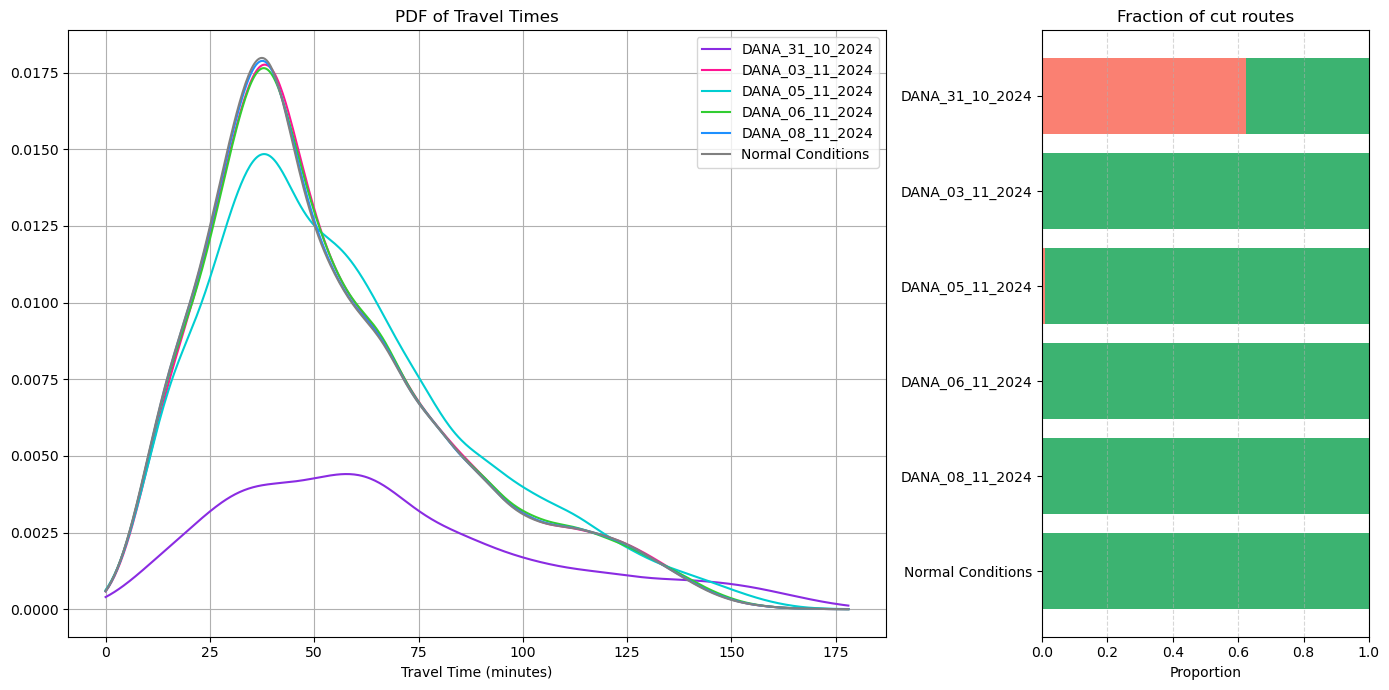

In [56]:

# --- Prepare data ---
plot_data = []
zero_counts = {}
all_counts = {}
layer_names = ["DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]

# T_P_lists scenarios
for name, results_dict in T_P_dictionaries.items():
    if name in layer_names:
        travel_times = [v[1] for v in results_dict.values()]
        non_zero_times = [t / 60 for t in travel_times if t > 0]
        all_times = [t / 60 for t in travel_times]
        zero_counts[name] = travel_times.count(0)
        all_counts[name] = len(travel_times)
        plot_data.append((name, non_zero_times))

# Add normal scenario
normal_travel_times = [v[1] for v in T_NP_dictionary.values()]
normal_non_zero = [t / 60 for t in normal_travel_times if t > 0]
normal_total = len(normal_travel_times)
plot_data.append(("Normal Conditions", normal_non_zero))
all_counts["Normal Conditions"] = normal_total
zero_counts["Normal Conditions"] = normal_travel_times.count(0)

# --- KDE Plot ---
fig, (ax_kde, ax_bar) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2.5, 1]})

x_vals = np.linspace(0, max([max(times) if times else 0 for _, times in plot_data]), 500)

for name, times in plot_data:
    if len(times) > 1:
        kde = gaussian_kde(times)
        y = kde(x_vals)
        ratio = len(times) / all_counts[name] if all_counts[name] > 0 else 0
        y_rescaled = y * ratio
        color = color_palette.get(name, 'gray')  # fallback to gray if not defined
        ax_kde.plot(x_vals, y_rescaled, label=name, color=color)

ax_kde.set_title("PDF of Travel Times")
ax_kde.set_xlabel("Travel Time (minutes)")
ax_kde.grid(True)
ax_kde.legend(loc='upper right')

# --- Reachability Bar Chart ---
scenarios = layer_names + ["Normal Conditions"]
reachable = [(all_counts[n] - zero_counts[n]) / all_counts[n] if all_counts[n] > 0 else 0 for n in scenarios]
unreachable = [1 - r for r in reachable]

bar_positions = np.arange(len(scenarios))
ax_bar.barh(bar_positions, unreachable, color='salmon', label='Unreachable')
ax_bar.barh(bar_positions, reachable, left=unreachable, color='mediumseagreen', label='Reachable')

ax_bar.set_yticks(bar_positions)
ax_bar.set_yticklabels(scenarios)
ax_bar.set_xlim(0, 1)
ax_bar.set_title("Fraction of cut routes")
ax_bar.set_xlabel("Proportion")
#ax_bar.legend(loc='lower right')
ax_bar.grid(axis='x', linestyle='--', alpha=0.5)

ax_bar.invert_yaxis()

plt.tight_layout()

plt.savefig('processed_files/Travel_times_DANA.png')
plt.show()

# Interactive Visualizations

In [57]:
# Set initial position
projected = study_area.to_crs(epsg=25830)
centroid_projected = projected.geometry.centroid.iloc[0]
centroid_latlon = gpd.GeoSeries([centroid_projected], crs=25830).to_crs(epsg=4326).geometry.iloc[0]
map_center = [centroid_latlon.y, centroid_latlon.x]
bounds_wgs84 = study_area.to_crs(epsg=4326).total_bounds
map_bounds = [[bounds_wgs84[1], bounds_wgs84[0]], [bounds_wgs84[3], bounds_wgs84[2]]]

## Areas at Risk and DANA Area (with roads)

In [58]:
m_1 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_1.fit_bounds(map_bounds)

In [59]:
if os.path.exists(graph_path):
    logging.info("Loading saved road network graph...")
    G = ox.load_graphml(graph_path)
else:
    logging.info("Downloading road network...")
    G = ox.graph_from_polygon(polygon, network_type="drive", simplify=True)
    ox.save_graphml(G, filepath=graph_path)
    logging.info("Graph saved.")

nodes, edges = ox.graph_to_gdfs(G)
logging.info("Converted graph to GeoDataFrames.")

2025-07-10 21:43:43,071 [INFO] Loading saved road network graph...
2025-07-10 21:43:58,857 [INFO] Converted graph to GeoDataFrames.


In [60]:
# Add flood zones
add_flood_zone_layer("10 yr", m_1)
add_flood_zone_layer("100 yr", m_1)
add_flood_zone_layer("500 yr", m_1)
add_flood_zone_layer("DANA_31_10_2024", m_1)
    
# Add flooded roads (optional)
add_roads_layer("10 yr", m_1, True)
add_roads_layer("100 yr", m_1, True)
add_roads_layer("500 yr", m_1, True)
add_roads_layer("DANA_31_10_2024", m_1, True)
add_roads_layer("Normal Conditions", m_1, False)

In [61]:
folium.LayerControl(collapsed=False).add_to(m_1)
m_1.save("processed_files/Risk_max_DANA.html")

In [62]:
del m_1

## DANA flood depth

In [63]:
m_2 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_2.fit_bounds(map_bounds)

In [64]:
depth=depth_zones["DANA_31_10_2024"]

In [65]:
min_depth = depth["depth_val"].min()
max_depth = depth["depth_val"].max()
depth_colormap = linear.YlGnBu_09.scale(min_depth, max_depth)
depth_colormap.caption = 'Flood Depth (m)'

folium.GeoJson(
    depth,
    name="DANA flood depth",
    style_function=lambda feature: {
        'fillColor': depth_colormap(feature['properties']['depth_val']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=["depth_val"], aliases=["Depth (m):"])
).add_to(m_2)

depth_colormap.add_to(m_2)

In [66]:
folium.LayerControl(collapsed=False).add_to(m_2)
m_2.save("processed_files/Max_flood_depth.html")

## DANA Flooded Area Evolution

In [67]:
m_3 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_3.fit_bounds(map_bounds)

In [68]:
# Add flood zones
add_flood_zone_layer("DANA_31_10_2024", m_3)
add_flood_zone_layer("DANA_03_11_2024", m_3)
add_flood_zone_layer("DANA_05_11_2024", m_3)
add_flood_zone_layer("DANA_06_11_2024", m_3)
add_flood_zone_layer("DANA_08_11_2024", m_3)
    
# Add flooded roads (optional)
add_roads_layer("DANA_31_10_2024", m_3, True)
add_roads_layer("DANA_03_11_2024", m_3, True)
add_roads_layer("DANA_05_11_2024", m_3, True)
add_roads_layer("DANA_06_11_2024", m_3, True)
add_roads_layer("DANA_08_11_2024", m_3, True)
add_roads_layer("Normal Conditions", m_3, False)

In [69]:
folium.LayerControl(collapsed=False).add_to(m_3)
m_3.save("processed_files/DANA_evolution.html")

## Road Risk

In [72]:
with open("processed_files/edge_risks_NP.json", "r") as f:
    delta_risks1 = json.load(f)
with open("processed_files/edge_risks_DANA.json", "r") as f:
    delta_risks2 = json.load(f)

# === Build delta dicts ===
def build_delta_dict(delta_list):
    return {
        tuple(item['edge']): item['delta_risk']
        for item in delta_list
    }

delta_dict1 = build_delta_dict(delta_risks1)
delta_dict2 = build_delta_dict(delta_risks2)

# === Signed log transform ===
def signed_log_transform(x):
    if x == 0:
        return 0
    return 1/(np.sign(x) * np.log10(abs(x)))

# === Get max absolute log ===
all_values = list(delta_dict1.values()) + list(delta_dict2.values())
transformed_values = [signed_log_transform(v) for v in all_values if v is not None]
max_abs_log = max(abs(val) for val in transformed_values)

# === Create custom diverging colormap ===
def inverted_colormap(val):
    """
    Maps log-transformed delta to color:
    - stronger values (larger abs(val)) → stronger color (closer to red/blue)
    - near-zero values → white
    """
    if val == 0:
        return "#ffffff"
    
    norm_val = signed_log_transform(val) / max_abs_log
    abs_norm = abs(norm_val)

    # invert strength: low abs → white, high abs → strong
    strength = abs_norm
    if norm_val > 0:
        # red side
        return cm.linear.Reds_09.scale(0, 1)(strength)
    else:
        # blue side
        return cm.linear.Blues_09.scale(0, 1)(strength)

# === Colorbar (caption only; not linked directly) ===
legend_colormap = cm.LinearColormap(
    colors=["blue", "white", "red"],
    vmin=-max_abs_log,
    vmax=+max_abs_log
)
legend_colormap.caption = "Δ Risk (Signed Log Scale, Stronger = Darker)"

# === Add edges to map ===
def add_edges_to_map(fmap, edges, delta_dict, label, filter_flood=False):
    fg = folium.FeatureGroup(name=label)

    for idx, row in edges.iterrows():
        edge_key = (row['u'], row['v']) if 'u' in row and 'v' in row else (idx[0], idx[1])

        if filter_flood and not row.get("in_flood_zone", False):
            continue

        value = delta_dict.get(edge_key)
        if value is None:
            continue

        # Determine color
        if value == 0:
            color = "#bbbbbb"
            opacity = 0.4
            weight = 1
        else:
            color = inverted_colormap(value)
            opacity = 0.8
            weight = 2

        coords = [(lat, lon) for lon, lat in row.geometry.coords]

        folium.PolyLine(
            locations=coords,
            color=color,
            weight=weight,
            opacity=opacity,
            tooltip=f"{edge_key} | Δ Risk: {value:.1e}"
        ).add_to(fg)

    fg.add_to(fmap)

# === Build map ===
m = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m.fit_bounds(map_bounds)

add_edges_to_map(m, edges, delta_dict1, label="All Roads")
add_edges_to_map(m, flood_edges_var["DANA_31_10_2024"], delta_dict2, label="DANA_31_10_2024", filter_flood=True)

m.add_child(legend_colormap)
folium.LayerControl().add_to(m)

m.save("processed_files/delta_risk_map.html")


In [73]:
from shapely.geometry import mapping
colormap = linear.YlOrRd_09.scale(0, 1)  # Yellow to red
colormap.caption = 'Municipality Value'

# Create base map
map_center = [
    sum([df['lat'].mean() for df in polygons]) / len(polygons),
    sum([df['lon'].mean() for df in polygons]) / len(polygons)
]
m = folium.Map(location=map_center, zoom_start=7, tiles="cartodbpositron")

# Add municipality polygons with color-coded fill
for gdf in polygons:
    name = gdf['name'].iloc[0]
    geometry = gdf['geometry'].iloc[0]
    value = compute_municipal_risk_factor(T_P_dictionaries["DANA_31_10_2024"], T_NP_dictionary, name)
    color = colormap(value)

    geo_json = mapping(geometry)
    folium.GeoJson(
        geo_json,
        tooltip=folium.Tooltip(f"{name}: {value:.2f}"),
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        }
    ).add_to(m)

    # Add label at centroid
    centroid = geometry.centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black;">{name}</div>""")
    ).add_to(m)

# Add color map legend
colormap.add_to(m)

# Display map
m.save("processed_files/municipality_risk_map.html")


In [74]:
municipal_risk_factor={}

for municipality in valencia_municipalities:
    try:
        place_name = f"{municipality}, Valencia, Spain"
        gdf = ox.geocode_to_gdf(place_name)

        if gdf.crs != "EPSG:4326":
            gdf = gdf.to_crs("EPSG:4326")

        polygons.append(gdf)
    except Exception as e:
        logging.warning(f"Error retrieving {municipality}: {e}", exc_info=True)

    # Add Mira from Cuenca (just in case)
    try:
        gdf = ox.geocode_to_gdf("Mira, Cuenca, Spain")
        if gdf.crs != "EPSG:4326":
            gdf = gdf.to_crs("EPSG:4326")
        polygons.append(gdf)
    except Exception as e:
        logging.warning(f"Error retrieving Mira: {e}", exc_info=True)

    municipal_risk_factor[municipality]=compute_municipal_risk_factor(T_P_dictionaries, T_NP_dict, municipality)

NameError: name 'T_NP_dict' is not defined

# Old Code